In [14]:
from mmda.types import *

In [15]:
import logging
logger = logging.getLogger(__name__)


In [51]:
from ai2_internal.figure_table_predictors.interface import Instance
import os
from ai2_internal import api
import mmda.types as mmda_types
import json

def resolve(file: str) -> str:
    return os.path.join('./test_fixtures', file)

def get_test_instance(sha) -> Instance:
    doc_file = resolve(f'test_doc_sha_{sha}.json')
    with open(doc_file) as f:
        dic_json = json.load(f)
    return dic_json

In [56]:
import time

def generate_content(sha):
    doc_json = get_test_instance(sha)
    doc = doc_json['doc']
    return {
      "symbols": doc['symbols'],
      "tokens": doc['tokens'],
      "pages": doc['pages'],
      "vila_span_groups": doc['vila_span_groups'],
      "blocks": doc_json['layout_equations'],
      }

def process_table_figure(content, local=True, multiple=1):
    if local:
        url='http://localhost:8080/invocations'
    else:
        url = 'http://mmda-figure-cap-pred.v2.prod.models.s2.allenai.org/invocations'

    start = time.time()
    try:
        result = requests.post(url, json={
          "instances": [content]*multiple})
    except requests.exceptions.ReadTimeout: 
        pass

    print(f'Call time: {time.time() - start} seconds')

    return (result, time.time() - start)

In [38]:
import numpy as np

In [39]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_table_figure_concurent(content, local=True, multiple=1, concurrent_requests=10):
    if local:
        url = 'http://localhost:8080/invocations'
    else:
        url = 'http://mmda-figure-cap-pred.v2.prod.models.s2.allenai.org/invocations'

    def send_request():
        start = time.time()
        try:
            result = requests.post(url, json={"instances": [content] * multiple}, timeout=120)
        except requests.exceptions.ReadTimeout:
            pass
        return time.time() - start

    with ThreadPoolExecutor(max_workers=concurrent_requests) as executor:
        futures = [executor.submit(send_request) for _ in range(concurrent_requests)]

    response_times = [future.result() for future in as_completed(futures)]

    print(f'Call times: {response_times} seconds')
    print(f'Average call time: {np.average(response_times):.2f} seconds std: {np.std(response_times):.2f}, concurent requests {concurrent_requests}')
    return response_times

In [57]:
content = generate_content('d0450478c38dda61f9943f417ab9fcdb2ebeae0a')

In [58]:
call_times = {}
for concurent_req in range(1, 10):
    call_times[concurent_req] = process_table_figure_concurent(content, local=False, multiple=1, concurrent_requests=concurent_req)

Call times: [1.400001049041748] seconds
Average call time: 1.40 seconds std: 0.00, concurent requests 1
Call times: [1.4494168758392334, 1.9214510917663574] seconds
Average call time: 1.69 seconds std: 0.24, concurent requests 2
Call times: [1.4738659858703613, 1.659148931503296, 1.9143550395965576] seconds
Average call time: 1.68 seconds std: 0.18, concurent requests 3
Call times: [1.6855049133300781, 1.7503199577331543, 2.171604871749878, 2.8290040493011475] seconds
Average call time: 2.11 seconds std: 0.46, concurent requests 4
Call times: [3.0311622619628906, 5.55782675743103, 5.702712059020996, 2.9607818126678467, 4.632144927978516] seconds
Average call time: 4.38 seconds std: 1.19, concurent requests 5
Call times: [4.024920225143433, 3.444732904434204, 2.084078073501587, 3.9703519344329834, 1.8279399871826172, 4.025630950927734] seconds
Average call time: 3.23 seconds std: 0.93, concurent requests 6
Call times: [2.4059410095214844, 3.4998137950897217, 2.4905200004577637, 3.460332

In [59]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Average response times (sec)')

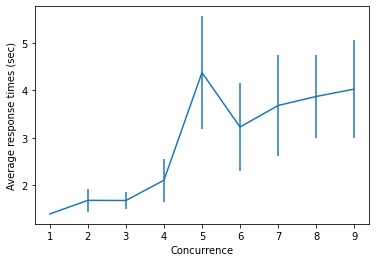

In [62]:
plt.errorbar(list(call_times.keys()), [np.average(response_times) for response_times in call_times.values()], 
            [np.std(response_times) for response_times in call_times.values()])
plt.xlabel('Concurrence')
plt.ylabel('Average response times (sec)')